# Using Naive Bayes to Classify Epitopes

The [Immune Epitope Database](http://www.iedb.org/) by disease id to find, e.g. epitopes from a viral, parasitic, or bacterial infection. The CSV files from these searches that are used for this notebook can be seen in the [data/iedb_epitopes](data/iedb_epitopes/) directory. These files contain ~14,000 epitopes from ~400 viruses, bacteria, and parasites.

In [1]:
import numpy as np
import pandas as pd
print pd.__version__

0.19.1


In [2]:
# This cell reads in the CSV files and creates training and test datasets.
from sklearn.model_selection import train_test_split

# All data for this notebook can be found in data_dir
data_dir = "data/iedb_epitopes/"

disease_groups = ["bacterial", "parasitic", "viral"]

def data_prep(group_name):
    df = pd.DataFrame.from_csv(data_dir + group_name + ".csv")
    df["disease_group"] = group_name
    df['disease_id'] = disease_groups.index(group_name)
    df.columns = [
        'type', 'epitope_sequence', 'start', 'end', 'chebi', 'syn', 'protein',
        'protein_id', 'organism', 'oid', 'comments', 'disease_group', 'disease_id'
    ]
    # Remove entries with '+' notation (note: looking into this, e.g. "PLNISLGDVVLY + DEAM(N3)")
    df = df[df.epitope_sequence.str.find('+') == -1]
    df = df[["epitope_sequence", "disease_group", "disease_id", "organism"]]
    
    df = df[df.duplicated(subset=["epitope_sequence"], keep=False) == False]
    return df

disease_dfs = []
for disease_group in disease_groups:
    disease_dfs.append(data_prep(disease_group))
  
print "Raw CSV files contains:"
group_describe = lambda name, df: "%16s: %3d unique organisms in %4d samples" % \
                            (name, df.organism.unique().shape[0], df.shape[0])
for (name, df) in zip(disease_groups, disease_dfs):
    print group_describe(name, df)
    
all_samples_df = disease_dfs[0]
for df in disease_dfs[1:]:
    all_samples_df = all_samples_df.append(df, ignore_index=True)

train, test = train_test_split(all_samples_df, test_size = 0.25)

print "\nCreated %d training and %d test samples" % (train.shape[0], test.shape[0])

Raw CSV files contains:
       bacterial:  79 unique organisms in 3468 samples
       parasitic:  61 unique organisms in 3431 samples
           viral: 263 unique organisms in 7937 samples

Created 11127 training and 3709 test samples


In [3]:
# This cell fits a model and then predicts the type of infections in the test set.
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'vect__ngram_range': [(1,3), (1,9), (1,12)],
              'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'tfidf__sublinear_tf': (True, False),
              'tfidf__norm': ("l1", "l2", None),
              'clf__alpha': (1e-1, 1e-2),
              'clf__fit_prior': (True, False)}

clf = Pipeline([('vect', CountVectorizer(analyzer='char', 
                                         lowercase=True, ngram_range=(1, 9))),
                ('tfidf', TfidfTransformer(norm=None, smooth_idf=True, 
                                           sublinear_tf=False, use_idf=False)),
                ('clf', MultinomialNB(alpha=0.01, fit_prior=True))
])

#clf = GridSearchCV(clf, parameters, n_jobs=-1)

print "Time to fit the model (%d samples)" % (train.shape[0])
%time clf.fit(train.epitope_sequence, train.disease_id)
print "\nTime to predict the values of test set (%d samples)" % (test.shape[0])
%time predicted = clf.predict(test.epitope_sequence)
print
print
print "Accuracy: %.2f%%\n" % (accuracy_score(test.disease_id, predicted) * 100)
print classification_report(test.disease_id, predicted, target_names=disease_groups)

cm = confusion_matrix(test.disease_id, predicted)
print "\n\nConfusion Matrix: rows = predictions, columns = actual\n"
row_format ="{:>15}" * (len(disease_groups)+1)
print row_format.format("", *disease_groups)
for disease, row in zip(disease_groups, cm):
    print row_format.format(disease, *row)

Time to fit the model (11127 samples)
CPU times: user 2.98 s, sys: 142 ms, total: 3.12 s
Wall time: 3.11 s

Time to predict the values of test set (3709 samples)
CPU times: user 512 ms, sys: 104 ms, total: 616 ms
Wall time: 547 ms


Accuracy: 87.17%

             precision    recall  f1-score   support

  bacterial       0.77      0.79      0.78       877
  parasitic       0.94      0.84      0.89       827
      viral       0.89      0.92      0.90      2005

avg / total       0.87      0.87      0.87      3709



Confusion Matrix: rows = predictions, columns = actual

                     bacterial      parasitic          viral
      bacterial            691             19            167
      parasitic             66            696             65
          viral            137             22           1846


In [4]:
import numpy as np
import pandas as pd
from math import log

amino_acids = {"A": "Alanine",
            "B": "Asparagine or Aspartic Acid",
            "C": "Cysteine",
            "D": "Aspartic Acid",
            "E": "Glutamic Acid",
            "F": "Phenylalanine",
            "G": "Glycine",
            "H": "Histidine",
            "I": "Isoleucine",
            "K": "Lysine",
            "L": "Leucine",
            "M": "Methionine",
            "N": "Asparagine",
            "P": "Proline",
            "Q": "Glutamine",
            "R": "Arginine",
            "S": "Serine",
            "T": "Threonine",
            "U": "Selenocysteine",
            "V": "Valine",
            "W": "Tryptophan",
            "Y": "Tyrosine",
            "Z": "Glutamine or Glutamic Acid"}

epitope_len_cutoff = int(np.percentile(all_samples_df.epitope_sequence.str.len(), 75)) 

def alphabet_dict():
    d = {}
    for letter in amino_acids.keys():
        d[letter] = 0
    return d

def init_counters():
    return [alphabet_dict() for i in range(epitope_len_cutoff)]

counters = {"bacterial": init_counters(),
            "viral": init_counters(),
            "parasitic": init_counters(),
            "fungal": init_counters(),
            "total": init_counters()}
for (rowid, seq, disease, disease_id, organism) in all_samples_df.itertuples():
    for (i, aa) in enumerate(seq[-epitope_len_cutoff::]):
        counters[disease][i][aa.upper()] += 1

for i in range(epitope_len_cutoff):
    for aa in amino_acids.keys():
        # TODO: readd fungal values?
        counters["total"][i][aa] += (counters["bacterial"][i][aa] \
                                    + counters["viral"][i][aa]\
                                    + counters["parasitic"][i][aa])
    
def prob(disease, pos, aa):
    counter = counters[disease][pos]
    total = 0
    for count in counter.values():
        total += count
    if counter[aa] == 0:
        return 0
    else:
        return float(counter[aa])/total
    
def safe_log(x):
    if x <= 0:
        return float("-inf")
    return log(x, 2.0)

def generate_kl_heatmap(disease):
    result = [alphabet_dict() for i in range(epitope_len_cutoff)]
    for i in range(epitope_len_cutoff):
        for letter in amino_acids.keys():
            result[i][letter] = prob(disease, i, letter) * safe_log( prob(disease, i, letter) / max(0.00000001, prob("total", i, letter)))

    r = pd.DataFrame(result).transpose()
    vmin = r.min().min()
    vmax = r.max().max()
    center = (vmax - vmin)/2

    import seaborn as sns
    sns.set()
    ax = sns.heatmap(r, linewidths=.5,
            yticklabels=["%s (%s)" % (amino_acids[code], code) for code in r.index],
            xticklabels=["%d" % (i) for i in range(epitope_len_cutoff-1, -1, -1)], 
            vmin=vmin, vmax=vmax, center=center, cmap="YlGnBu", alpha=0.8)
    ax.set_title('%s Kullback-Leibler, $I(i) = \sum_{L=0}^{N}p_{i}^{L}\log_2(p_{i}^{L}/q_{i}^{L})$' % (disease))
    print "Zero on X-axis is the C terminus"

Zero on X-axis is the C terminus


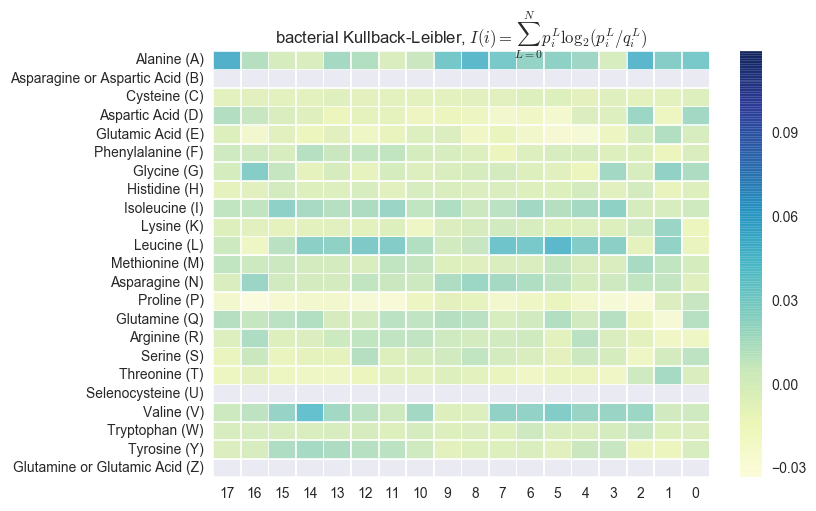

In [5]:
%matplotlib inline
generate_kl_heatmap("bacterial")

Zero on X-axis is the C terminus


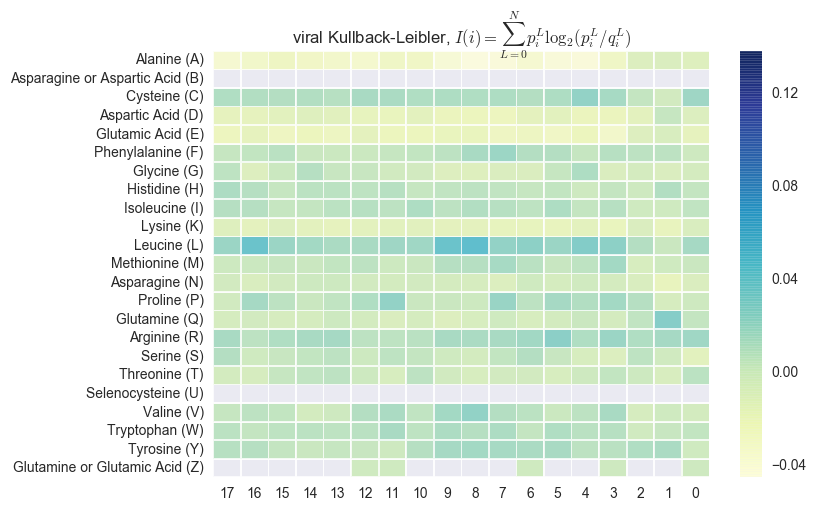

In [6]:
%matplotlib inline
generate_kl_heatmap("viral")

Zero on X-axis is the C terminus


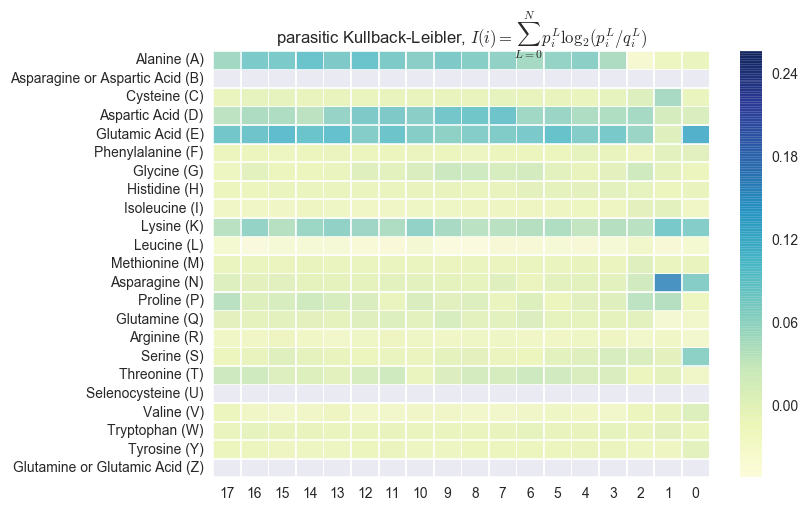

In [7]:
%matplotlib inline
generate_kl_heatmap("parasitic")